In [1]:
import sys
sys.path.append('..')
sys.path.append('../..')

import copy
import math
import pickle

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import wandb
from torch.optim.lr_scheduler import SequentialLR, LinearLR, ExponentialLR, CosineAnnealingLR
from torch.utils.data import DataLoader, Subset, random_split
from itertools import groupby
from operator import itemgetter

from data_utils import *
from model import *
from waveforms.waveforms_module.make_waveform import BatchedLightSimulation

seed = 42
torch.manual_seed(42)

In [2]:
path = '/sdf/home/c/carsmith/sdf_data/flash_detection_data/flash_files/delay_200ks/labelled_2_8_val.npy'
loader = make_labelled_dataloader(path, seed=seed)

/sdf/home/c/carsmith/flash_reconstruction/self_supervised_flash/data_utils.py:85: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  self.token_labels = torch.tensor(data['token_labels']).int()


hit_times: torch.Size([25, 8])
Batch shape:  torch.Size([25, 1, 8000])
Arrival times shape:  torch.Size([25, 1, 8000])
Photon bins shape:  torch.Size([25, 1, 8000])
torch.Size([8000])
Total photons in wf:  1640


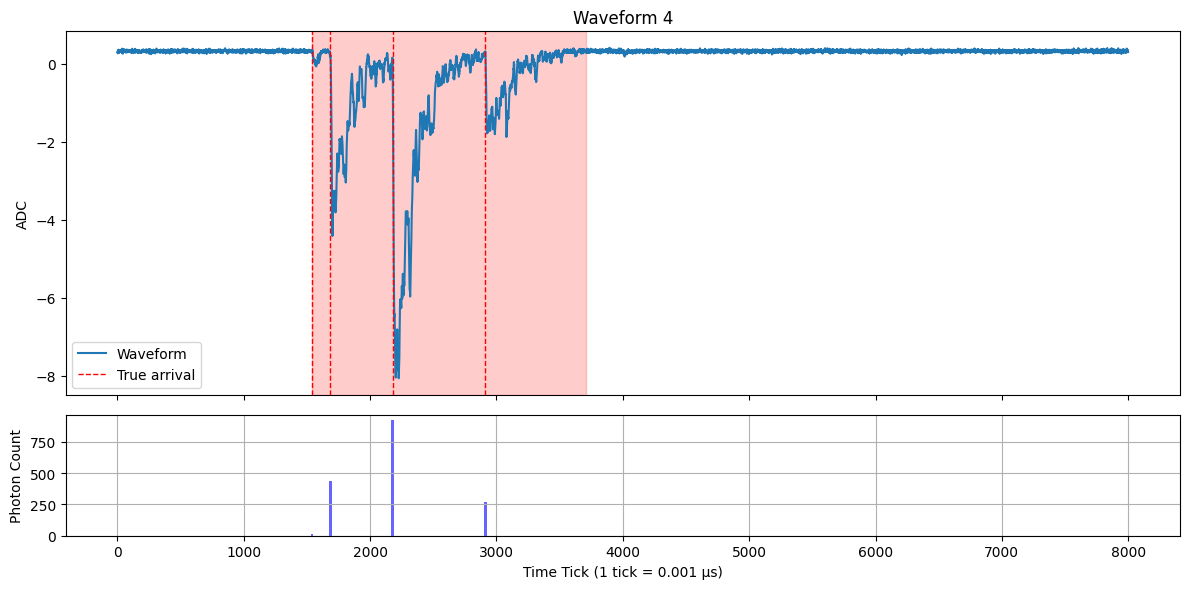

In [3]:
waveforms, arrival_times, hit_times, photon_bins, photon_list, token_labels = next(iter(loader))
print(f"hit_times: {hit_times.shape}")
print('Batch shape: ', waveforms.shape)
print('Arrival times shape: ', arrival_times.shape)
print('Photon bins shape: ', photon_bins.shape)

waveform_id = 4
wf = waveforms[waveform_id]  # [1, L]
ticks = torch.arange(wf.shape[-1])  # [0, 1, ..., L-1]
wf = wf.squeeze(0)  # [L]

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(12, 6), sharex=True,
    gridspec_kw={'height_ratios': [3, 1]}
)

# --- Top panel: waveform ---
ax1.plot(ticks, wf, alpha=1, label='Waveform')

# Mark true hits
for j, t in enumerate(hit_times[waveform_id]):
    if t >= 0:
        ax1.axvline(
            x=t.item(), 
            color='r', 
            linestyle='--', 
            linewidth=1, 
            label='True arrival' if j == 0 else ""
        )
        
# Highlight signal regions based on labels
labels = np.repeat(token_labels[waveform_id], 10)
print(labels.shape)
signal_bins = np.where(labels == 1)[0]

# Group contiguous sequences in repeated array
for k, g in groupby(enumerate(signal_bins), lambda ix: ix[0] - ix[1]):
    group = list(map(itemgetter(1), g))
    ax1.axvspan(group[0], group[-1], color='red', alpha=0.2)

ax1.set_title(f"Waveform {waveform_id}")
ax1.set_ylabel("ADC")
ax1.legend()

# --- Bottom panel: photon counts ---
photon_counts = photon_bins[waveform_id].cpu().numpy()
print("Total photons in wf: ", photon_counts[0].sum())
ax2.bar(ticks, photon_counts[0], width=20.0, color='b', alpha=0.6)
ax2.set_ylabel("Photon Count")
ax2.set_xlabel("Time Tick (1 tick = 0.001 μs)")
ax2.grid()
plt.tight_layout()
plt.show()

### Load a Checkpoint

In [4]:
# Load the checkpoint
device = 'cuda'
model = ConformerModel()
model.to(device)
checkpoint = torch.load(f"/sdf/home/c/carsmith/sdf_data/self_supervised_flash/dino_mask80_token10_5epochs.pth", weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

ConformerModel(
  (tokenizer): MultiLevelTokenizer(
    (convs): ModuleList(
      (0): Conv1d(1, 256, kernel_size=(20,), stride=(1,), padding=(10,))
      (1): Conv1d(1, 256, kernel_size=(50,), stride=(1,), padding=(25,))
      (2): Conv1d(1, 256, kernel_size=(100,), stride=(1,), padding=(50,))
      (3): Conv1d(1, 256, kernel_size=(400,), stride=(1,), padding=(200,))
    )
    (downsample): Sequential(
      (0): Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): GELU(approximate='none')
      (2): Conv1d(256, 256, kernel_size=(10,), stride=(10,), groups=256, bias=False)
      (3): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
    )
    (proj): Conv1d(1024, 256, kernel_size=(1,), stride=(1,))
  )
  (positional_encoding): PositionalEncoding()
  (conformer): Conformer(
    (conformer_layers): ModuleList(
      (0-3): 4 x ConformerLayer(
        (ffn1): _FeedForwardModule(
          (sequential): Sequential(
            (0): LayerNorm((256,), eps=1e-05, elementwi

### Silhouette Score (Clustering)

In [5]:
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [6]:
# Extract some embeddings
val_progress = tqdm(loader, desc="Scanning", leave=False, position=0)

all_val_embeddings = []
all_token_labels = []

with torch.no_grad():
    for data, target, hit_times, photon_target, photon_list, token_labels in val_progress:
        data = data.to(device)
        embeddings = model(data)
        all_val_embeddings.append(embeddings.cpu())  # store on CPU to save GPU memory
        all_token_labels.append(token_labels)

all_val_embeddings = torch.cat(all_val_embeddings, dim=0)
all_token_labels = torch.cat(all_token_labels, dim=0)
print(all_val_embeddings.shape)
print(all_token_labels.shape)

torch.Size([100000, 800, 20])
torch.Size([100000, 800])


### Silhouette Score

In [7]:
# Cluster and calculate a silhouette score
# B, T, D = all_val_embeddings.shape
# X = all_val_embeddings.reshape(B * T, D) # consider cluster for all tokens independently

# X = StandardScaler().fit_transform(X)

# idx = torch.randperm(B*T)[:100000]
# X_subset = X[idx]

# n_clusters = 7
# kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=10000, random_state=42)
# cluster_labels = kmeans.fit_predict(X_subset)

# sil_score = silhouette_score(X_subset, cluster_labels)
# print(f"Silhouette score for {n_clusters} clusters: {sil_score:.3f}")

In [8]:
# print(np.unique(cluster_labels))
# # 10 clusters: 0.229
# # 7 clusters: 0.234
# # 5 clusters: 0.271
# # 2 clusters: 0.247
# n_clusters = [2, 5, 7, 10]
# scores = [0.247, 0.271, 0.234, 0.229]
# plt.plot(n_clusters, scores, marker='o')
# plt.title("Silhouette Scores for Diff. # Clusters")
# plt.xlabel("# Clusters")
# plt.ylabel("Silhouette Score")

In [9]:
# Project & Plot Clusters
# X_pca = PCA(n_components=2).fit_transform(X_subset)
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='tab10', s=5)
# plt.title(f"KMeans clustering (k={n_clusters})")
# plt.xlabel("PCA 1")
# plt.ylabel("PCA 2")
# plt.show()

### t-SNE

In [ ]:
from sklearn.manifold import TSNE

B, T, D = all_val_embeddings.shape
X = all_val_embeddings.reshape(B * T, D) # consider cluster for all tokens independently
Y = all_token_labels.reshape(B*T) # 2 classes, 0 and 1
print(X.shape, Y.shape)

X = StandardScaler().fit_transform(X) # normalizing

idx = torch.randperm(B*T)[:100000]
X_subset = X[idx]
Y_subset = Y[idx]

tsne = TSNE(
    n_components=2,      # 2D embedding
    perplexity=5,       # typical values: 5-50
    learning_rate=200,   # default 200
    n_iter=1000,         # number of iterations
    random_state=42,
    verbose=1
)

embedding = tsne.fit_transform(X_subset)

torch.Size([80000000, 20]) torch.Size([80000000])


In [ ]:
plt.figure(figsize=(8, 6))
for label in np.unique(Y_subset):
    idx = (Y_subset == label)
    if label == 0: l = 'background'
    elif label == 1: l = 'signal'
    plt.scatter(embedding[idx, 0], embedding[idx, 1], label=f"{l}", s=10, alpha=0.7)
plt.legend()
plt.title("t-SNE Clustering with Labels")
plt.show()

Index(['Step', 'mask50_token10 - train_loss',
       'mask50_token10 - train_loss__MIN', 'mask50_token10 - train_loss__MAX',
       'mask80_token10 - train_loss', 'mask80_token10 - train_loss__MIN',
       'mask80_token10 - train_loss__MAX'],
      dtype='object')


Text(0.5, 1.0, 'Masked Vanilla DINO Training Loss')

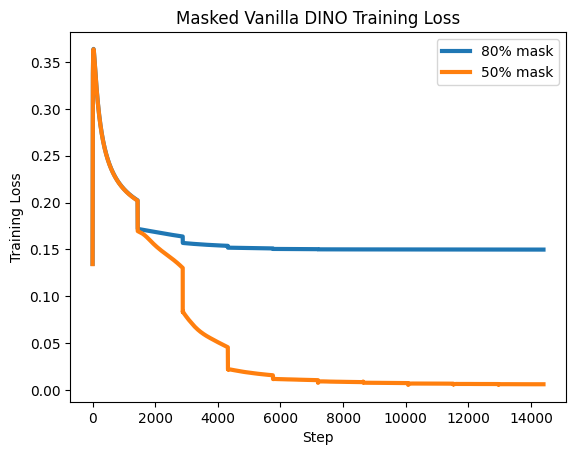

In [35]:
import pandas as pd
training_data = pd.read_csv('masked_training.csv')
print(training_data.keys())
plt.plot(training_data['Step'], training_data['mask80_token10 - train_loss'], label='80% mask', linewidth=3)
plt.plot(training_data['Step'], training_data['mask50_token10 - train_loss'], label='50% mask', linewidth=3)
plt.legend()
plt.xlabel('Step')
plt.ylabel('Training Loss')
plt.title('Masked Vanilla DINO Training Loss') 